## Librerias a utilizar

In [1]:
%pip install kmodes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kprototypes import KPrototypes  # Para el modelo de segmentación
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import spearmanr, chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


Note: you may need to restart the kernel to use updated packages.


## Cargamos los datos

In [2]:
# Cargar el archivo Excel
df = pd.read_excel("ConsolidadorespuestasWSP.xlsx")

In [3]:
df.head()

,Periodo,waid,rut,edad,template,status,tag,created,id_case,message_text_first_response,Mensaje,message_time_first_response,GRUPO DE CONTROL
0,202401,56996447326,0170108051,34.04650,afp_capital_clientes_variables_unicas_wr,Read by recipient,NaN,2024-01-26 11:43:20.0,NaN,"SI, necesito ayuda",Necesito ayuda,2024-01-26 12:07:59.0,NaN
1,202401,56991345917,0145643856,45.40260,afp_capital_clientes_variables_unicas_wr,Read by recipient,NaN,2024-01-26 11:41:20.0,NaN,"SI, necesito ayuda",Necesito ayuda,2024-01-26 12:03:14.0,NaN
2,202401,56989588344,0165273184,37.71555,afp_capital_clientes_variables_unicas_wr,Read by recipient,NaN,2024-01-26 11:40:40.0,NaN,"SI, necesito ayuda",Necesito ayuda,2024-01-26 11:41:22.0,NaN
3,202401,56987354893,0180256458,30.19125,afp_capital_clientes_variables_unicas_wr,Received by recipient,NaN,2024-01-26 11:40:00.0,NaN,Gracias por comunicarte con Veterinaria Fauna....,Necesito ayuda,2024-01-26 11:40:14.0,NaN
4,202401,56987212398,0137695189,49.18085,afp_capital_clientes_variables_unicas_wr,Read by recipient,NaN,2024-01-26 11:40:00.0,NaN,"SI, necesito ayuda",Necesito ayuda,2024-01-26 11:40:49.0,NaN


## Agregamos columnas, para intervalos de edad y estacion

### Para ciertos templates como war_room_sept_acceso_web y trx_wr_var_unica_sept... la respuesta "Necesito ayuda" se considera positiva y derivará al ejecutivo, mientras que "Sí, pude" será negativa y se calificará con 0. En el caso del template "Gracias, lo revisaré", esta será la respuesta negativa y también tendrá un 0. Cualquier otra respuesta fuera de estas opciones se calificará con -1, ya que se considera incoherente o automatizada, lo que dificulta la identificación de patrones.

In [42]:
# Crear columna de intervalo de edad
bins = [0, 20, 30, 40, 50, 60, 100]
labels = ["0-20", "21-30", "31-40", "41-50", "51-60", "61+"]
df["intervalo_edad"] = pd.cut(df["edad"], bins=bins, labels=labels)

def obtener_estacion(fecha):
    mes = fecha.month
    dia = fecha.day

    if (mes == 12 and dia >= 21) or (mes == 1) or (mes == 2) or (mes == 3 and dia < 21):
        return "Verano"
    elif (mes == 3 and dia >= 21) or (mes == 4) or (mes == 5) or (mes == 6 and dia < 21):
        return "Otoño"
    elif (mes == 6 and dia >= 21) or (mes == 7) or (mes == 8) or (mes == 9 and dia < 21):
        return "Invierno"
    else:
        return "Primavera"

df["created"] = pd.to_datetime(df["created"])
df["estacion"] = df["created"].apply(obtener_estacion)

# Crear columna de hora
df["hora"] = df["created"].dt.hour

# Crear columna de día de la semana
df["dia_semana"] = df["created"].dt.day_name()

# Clasificar respuestas de primer mensaje
def clasificar_respuesta(texto):
    if isinstance(texto, str):
        if texto.lower().startswith("si"):
            return 1
        elif texto.lower().startswith("no"):
            return 0
        
    return -1

df["clasificacion_respuesta"] = df["message_text_first_response"].apply(clasificar_respuesta)

# Mostrar el dataframe con las nuevas columnas
print(df.head())

       edad                                  template                 status  \
0  34.04650  afp_capital_clientes_variables_unicas_wr      Read by recipient   
1  45.40260  afp_capital_clientes_variables_unicas_wr      Read by recipient   
2  37.71555  afp_capital_clientes_variables_unicas_wr      Read by recipient   
3  30.19125  afp_capital_clientes_variables_unicas_wr  Received by recipient   
4  49.18085  afp_capital_clientes_variables_unicas_wr      Read by recipient   

              created                        message_text_first_response  \
0 2024-01-26 11:43:20                                 SI, necesito ayuda   
1 2024-01-26 11:41:20                                 SI, necesito ayuda   
2 2024-01-26 11:40:40                                 SI, necesito ayuda   
3 2024-01-26 11:40:00  Gracias por comunicarte con Veterinaria Fauna....   
4 2024-01-26 11:40:00                                 SI, necesito ayuda   

          Mensaje message_time_first_response intervalo_edad e

In [5]:
target_templates = df['template'].unique().tolist()
print("Templates in df:", target_templates)

Templates in df: ['afp_capital_clientes_variables_unicas_wr', nan, 'afp_capital_clientes_acceso_web_wr', 'afp_capital_clientes_variables_unicas_war_room', 'afp_capital_cliente_sin_contacto_sin_transacciones_wr', 'afp_capital_sin_contacto_propensos', 'afp_capital_clientes_variables_unicas_wr_v3', 'afp_capital_clientes_variables_unicas_wr_v2', 'afp_capital_clientes_acceso_web_war_room', 'afp_capital_clientes_acceso_web_war_room_v2', 'afp_capital_clientes_variables_unicas_war_room_trx', 'afp_capital_wr_sugerencia_fondo_rentabilidad_wr', 'afp_capital_clientes_wr_acceso_web_wr', 'afp_capital_clientes_rentabilidad_y_sugerencia_de_fondos_wr', 'war_room_transacciones_web_v1', 'template', '2024-08-02 12:49:26.0', 'abtest_agosto_wr_sdf_fondo', 'abtest_final_agosto_wr_sdf_fondo', 'capital_directo_licencia_medica_agosto', 'afp_capital_retencion_ejecutivo_no_vigente', 'afp_capital_wr_abtest_agosto_wr_sdf_fondo', 'agosto_abtest_sdf_wr_perfil', 'lc_abtest_wr_multiaportes', 'lclc_abtest_wr_cartolam', 

In [45]:
# Mostrar la cantidad de valores 1, 0 y -1 en la columna 'clasificacion_respuesta'
print("Conteo de valores en 'clasificacion_respuesta':")
print(df["clasificacion_respuesta"].value_counts())

Conteo de valores en 'clasificacion_respuesta':
clasificacion_respuesta
-1    396527
 0     15097
 1     13996
Name: count, dtype: int64


In [49]:
# Modificar "clasificacion_respuesta" basado en el mensaje exacto de "message_text_first_response"
df.loc[df["message_text_first_response"].str.strip() == "Si, pude", "clasificacion_respuesta"] = 0
df.loc[df["message_text_first_response"].str.strip() == "Gracias, lo revisaré", "clasificacion_respuesta"] = 0
df.loc[df["message_text_first_response"].str.strip() == "Necesito ayuda", "clasificacion_respuesta"] = 1

In [50]:
# Mostrar la cantidad de valores 1, 0 y -1 en la columna 'clasificacion_respuesta'
print("Conteo de valores en 'clasificacion_respuesta':")
print(df["clasificacion_respuesta"].value_counts())

Conteo de valores en 'clasificacion_respuesta':
clasificacion_respuesta
-1    395645
 0     21760
 1      8215
Name: count, dtype: int64


In [51]:
df_ayuda = df[df["message_text_first_response"].str.contains("Si, pude", case=False, na=False)]
print(df_ayuda[["message_text_first_response", "clasificacion_respuesta"]])

       message_text_first_response  clasificacion_respuesta
95826                     Si, pude                        0
95827                     Si, pude                        0
95828                     Si, pude                        0
95829                     Si, pude                        0
95830                     Si, pude                        0
...                            ...                      ...
424451                    Si, pude                        0
424453                    Si, pude                        0
424497                    Si, pude                        0
426937                    Si, pude                        0
440219                    Si, pude                        0

[6497 rows x 2 columns]


### Cambio de formato a datetime y creacion de columna tiempo_respuesta

In [52]:
# Convertir las columnas de tiempo a formato datetime
df["created"] = pd.to_datetime(df["created"])
df["message_time_first_response"] = pd.to_datetime(df["message_time_first_response"])

# Calcular la diferencia de tiempo
df["tiempo_respuesta"] = df["message_time_first_response"] - df["created"]

# Mostrar el DataFrame con la nueva columna
print(df[["created", "message_time_first_response", "tiempo_respuesta"]].head())


              created message_time_first_response tiempo_respuesta
0 2024-01-26 11:43:20         2024-01-26 12:07:59  0 days 00:24:39
1 2024-01-26 11:41:20         2024-01-26 12:03:14  0 days 00:21:54
2 2024-01-26 11:40:40         2024-01-26 11:41:22  0 days 00:00:42
3 2024-01-26 11:40:00         2024-01-26 11:40:14  0 days 00:00:14
4 2024-01-26 11:40:00         2024-01-26 11:40:49  0 days 00:00:49


### Para un analisis mas preciso la columna de tiempo_respuesta que esta en horas se pasa a minutos

In [53]:
df["tiempo_respuesta_minutos"] = df["tiempo_respuesta"].dt.total_seconds() / 60

# Eliminacion de valores atipicos

### Eliminamos las filas repetidas, que no aportan ningun valor, tambien los tiempos de respuesta que sobrepasan las 8 horas y 20 minutos son eliminados, ya que un cliente puede haber respondido luego de varios dias enviado el mensaje y afectaria demasiado al promedio 

In [ ]:
# Eliminar columnas irrelevantes
columnas_irrelevantes = ["tag", "id_case", "GRUPO DE CONTROL", "rut", "waid", "Periodo"]
df = df.drop(columns=columnas_irrelevantes)


# Eliminar filas duplicadas (si las hay)
df = df.drop_duplicates()


Número de filas duplicadas: 7137
Valores faltantes por columna:
edad                                0
template                        17369
status                              1
created                             1
message_text_first_response    401031
Mensaje                        429552
message_time_first_response    400935
intervalo_edad                   9343
estacion                            0
hora                                1
dia_semana                          1
clasificacion_respuesta             0
tiempo_respuesta               400935
tiempo_respuesta_minutos       400935
dtype: int64
       edad                                  template                 status  \
0  34.04650  afp_capital_clientes_variables_unicas_wr      Read by recipient   
1  45.40260  afp_capital_clientes_variables_unicas_wr      Read by recipient   
2  37.71555  afp_capital_clientes_variables_unicas_wr      Read by recipient   
3  30.19125  afp_capital_clientes_variables_unicas_wr  Received by reci

In [11]:
# Filtrar filas con tiempo_respuesta_minutos entre 0 y 1000 minutos (incluyendo 0 y 1000)
mask = (df["tiempo_respuesta_minutos"] >= 0) & (df["tiempo_respuesta_minutos"] <= 500)
count = mask.sum()

print("Número de datos con tiempo de respuesta entre 0 y 500 minutos:", count)

Número de datos con tiempo de respuesta entre 0 y 500 minutos: 35936


### Observacion: Las edades de 0-20 corresponden a extranjeros probablemente, dado que obtuve la edad aproximada con fines estadisticos a partir del RUT del cliente, los extranjeros suelen tener un RUT sobre los 21 millones, por lo que no son considerados para el analisis

In [12]:
# Filtrar el DataFrame para conservar filas donde:
# - El tiempo_respuesta_minutos esté entre 0 y 500 (inclusive)
# - O sea NaN
df = df[(df["tiempo_respuesta_minutos"].isna()) | ((df["tiempo_respuesta_minutos"] >= 0) & (df["tiempo_respuesta_minutos"] <= 500))]

# Mostrar la nueva dimensión del DataFrame para verificar el filtrado
print("Dimensiones del DataFrame filtrado:", df.shape)

Dimensiones del DataFrame filtrado: (436871, 14)


### La mayoria de los valores se mantienen, no se pierden muchos datos luego de la limpieza

### Distribucion luego del filtrado de tiempo de respuestas a igual o menos de 500 minutos

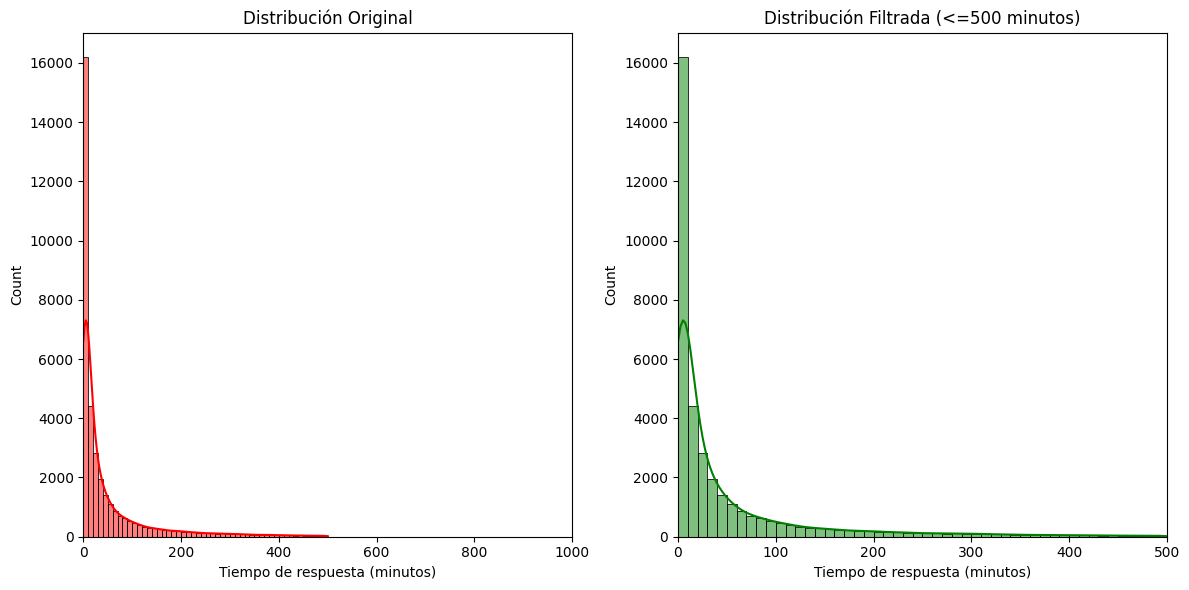

In [13]:
plt.figure(figsize=(12, 6))

# Gráfico original (sin filtrar)
plt.subplot(1, 2, 1)
sns.histplot(df["tiempo_respuesta_minutos"], bins=50, kde=True, color="red")
plt.title("Distribución Original")
plt.xlabel("Tiempo de respuesta (minutos)")
plt.xlim(0, 1000)  # Ajustar el eje X para visualizar mejor

# Gráfico filtrado (<=500 minutos)
plt.subplot(1, 2, 2)
sns.histplot(df["tiempo_respuesta_minutos"], bins=50, kde=True, color="green")
plt.title("Distribución Filtrada (<=500 minutos)")
plt.xlabel("Tiempo de respuesta (minutos)")
plt.xlim(0, 500)

plt.tight_layout()
plt.show()

# Analisis de tiempos de respuesta


In [14]:
# Calcular el tiempo promedio de respuesta en minutos
tiempo_promedio_respuesta = df["tiempo_respuesta"].dt.total_seconds().mean() / 60
print(f"Tiempo promedio de respuesta: {tiempo_promedio_respuesta:.2f} minutos")

Tiempo promedio de respuesta: 48.41 minutos


C:\Users\luis\AppData\Local\Temp\ipykernel_23480\1232656514.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tiempo_por_hora, x="hora", y="tiempo_respuesta", palette="viridis")


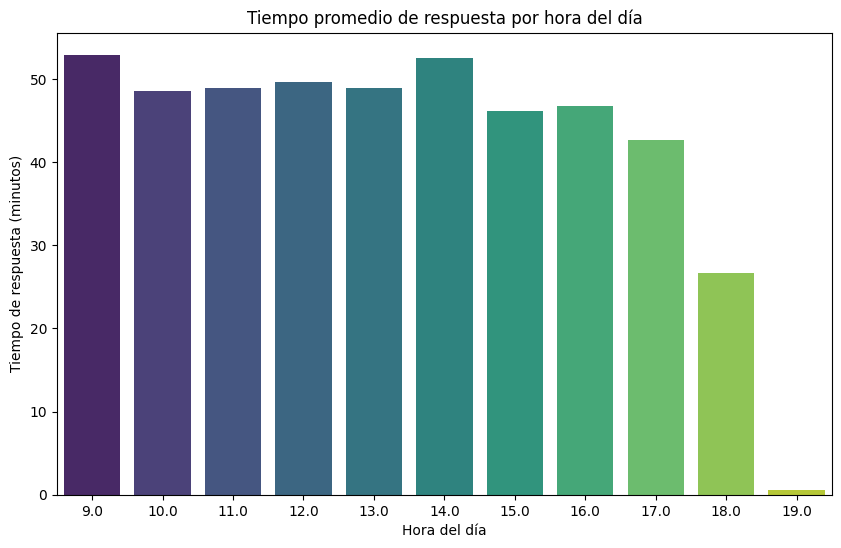

In [15]:
# Agrupar por hora y calcular el tiempo promedio de respuesta
tiempo_por_hora = df.groupby("hora")["tiempo_respuesta"].apply(lambda x: x.dt.total_seconds().mean() / 60).reset_index()

# Gráfico de tiempo de respuesta por hora
plt.figure(figsize=(10, 6))
sns.barplot(data=tiempo_por_hora, x="hora", y="tiempo_respuesta", palette="viridis")
plt.title("Tiempo promedio de respuesta por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Tiempo de respuesta (minutos)")
plt.show()

C:\Users\luis\AppData\Local\Temp\ipykernel_23480\3138892304.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tiempo_por_dia, x="dia_semana", y="tiempo_respuesta", palette="magma")


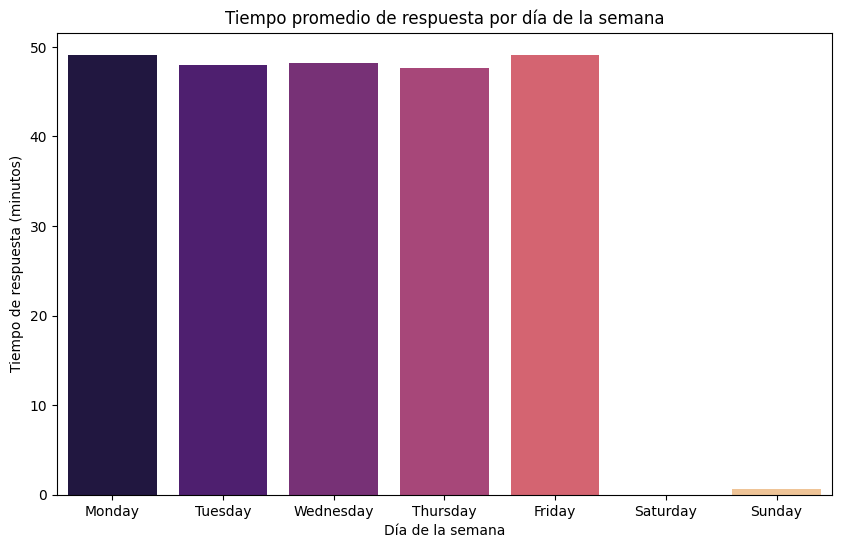

In [16]:
# Agrupar por día de la semana y calcular el tiempo promedio de respuesta
tiempo_por_dia = df.groupby("dia_semana")["tiempo_respuesta"].apply(lambda x: x.dt.total_seconds().mean() / 60).reset_index()

# Ordenar los días de la semana
dias_ordenados = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
tiempo_por_dia["dia_semana"] = pd.Categorical(tiempo_por_dia["dia_semana"], categories=dias_ordenados, ordered=True)
tiempo_por_dia = tiempo_por_dia.sort_values("dia_semana")

# Gráfico de tiempo de respuesta por día de la semana
plt.figure(figsize=(10, 6))
sns.barplot(data=tiempo_por_dia, x="dia_semana", y="tiempo_respuesta", palette="magma")
plt.title("Tiempo promedio de respuesta por día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Tiempo de respuesta (minutos)")
plt.show()

C:\Users\luis\AppData\Local\Temp\ipykernel_23480\3445707295.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tiempo_por_estacion, x="estacion", y="tiempo_respuesta", palette="coolwarm")


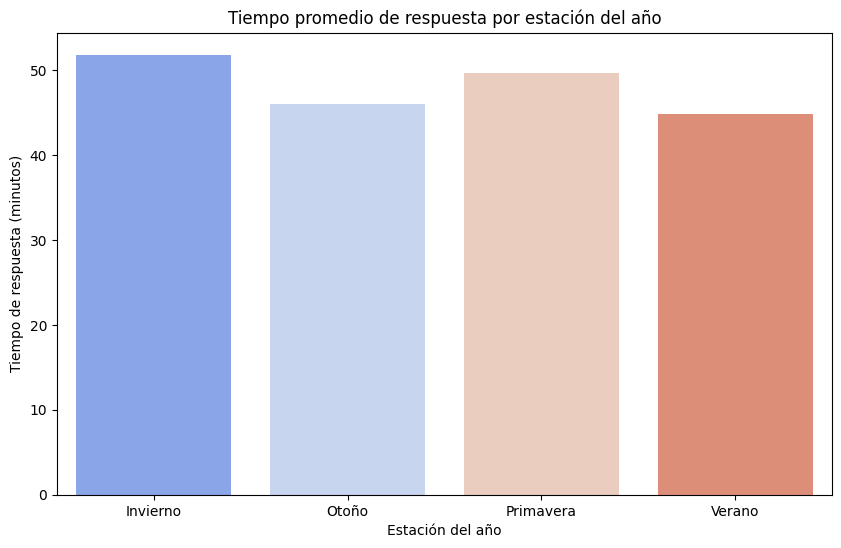

In [54]:
# Agrupar por estación y calcular el tiempo promedio de respuesta
tiempo_por_estacion = df.groupby("estacion")["tiempo_respuesta"].apply(lambda x: x.dt.total_seconds().mean() / 60).reset_index()

# Gráfico de tiempo de respuesta por estación
plt.figure(figsize=(10, 6))
sns.barplot(data=tiempo_por_estacion, x="estacion", y="tiempo_respuesta", palette="coolwarm")
plt.title("Tiempo promedio de respuesta por estación del año")
plt.xlabel("Estación del año")
plt.ylabel("Tiempo de respuesta (minutos)")
plt.show()

Tiempo promedio de respuesta (minutos):
Con 'necesito ayuda': 44.65
Sin 'necesito ayuda': 48.54


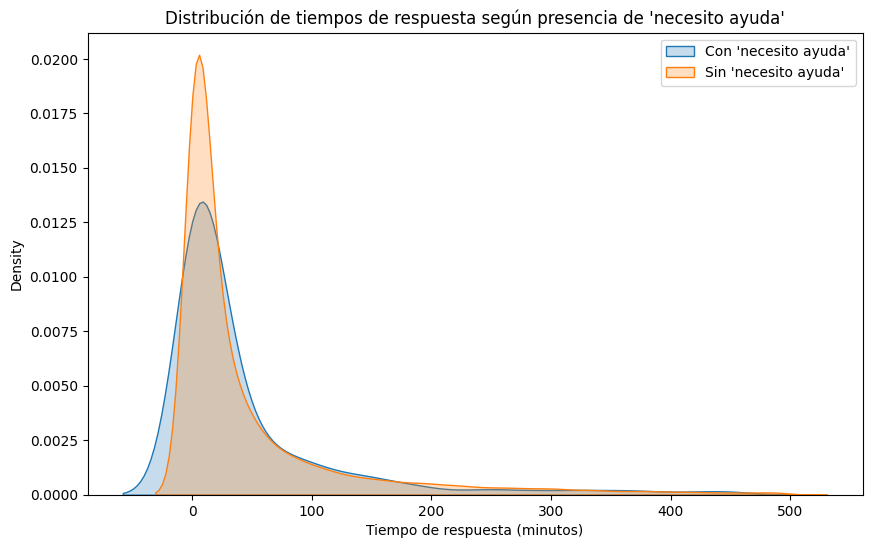

In [18]:
# Filtrar los mensajes que contienen la palabra clave "necesito ayuda"
mask_ayuda = df["message_text_first_response"].str.contains("necesito ayuda", case=False, na=False)

# Calcular el tiempo de respuesta promedio para cada grupo
avg_with = df.loc[mask_ayuda, "tiempo_respuesta_minutos"].mean()
avg_without = df.loc[~mask_ayuda, "tiempo_respuesta_minutos"].mean()

print("Tiempo promedio de respuesta (minutos):")
print(f"Con 'necesito ayuda': {avg_with:.2f}")
print(f"Sin 'necesito ayuda': {avg_without:.2f}")

# Graficar la distribución de tiempos de respuesta para cada grupo
plt.figure(figsize=(10,6))
sns.kdeplot(df.loc[mask_ayuda, "tiempo_respuesta_minutos"].dropna(), label="Con 'necesito ayuda'", fill=True)
sns.kdeplot(df.loc[~mask_ayuda, "tiempo_respuesta_minutos"].dropna(), label="Sin 'necesito ayuda'", fill=True)
plt.xlabel("Tiempo de respuesta (minutos)")
plt.title("Distribución de tiempos de respuesta según presencia de 'necesito ayuda'")
plt.legend()
plt.show()

C:\Users\luis\AppData\Local\Temp\ipykernel_23480\2270952208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tiempo_por_clasificacion, x="clasificacion_respuesta", y="tiempo_respuesta_minutos", palette="Set2")


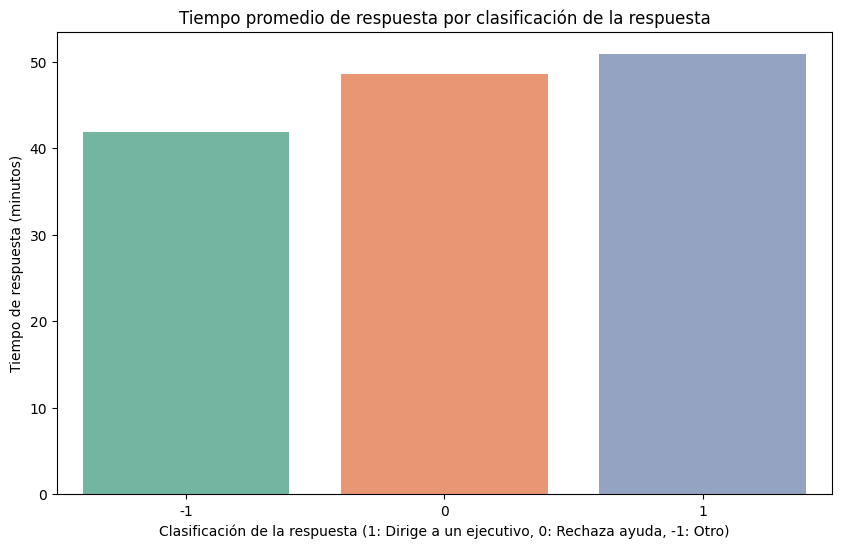

In [19]:
# Agrupar por clasificación de la respuesta y calcular el tiempo promedio de respuesta
tiempo_por_clasificacion = df.groupby("clasificacion_respuesta")["tiempo_respuesta_minutos"].mean().reset_index()

# Gráfico de tiempo de respuesta por clasificación
plt.figure(figsize=(10, 6))
sns.barplot(data=tiempo_por_clasificacion, x="clasificacion_respuesta", y="tiempo_respuesta_minutos", palette="Set2")
plt.title("Tiempo promedio de respuesta por clasificación de la respuesta")
plt.xlabel("Clasificación de la respuesta (1: Dirige a un ejecutivo, 0: Rechaza ayuda, -1: Otro)")
plt.ylabel("Tiempo de respuesta (minutos)")
plt.show()

# Interaccion por dia

C:\Users\luis\AppData\Local\Temp\ipykernel_23480\4123092239.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="dia_semana", order=order, palette="viridis")


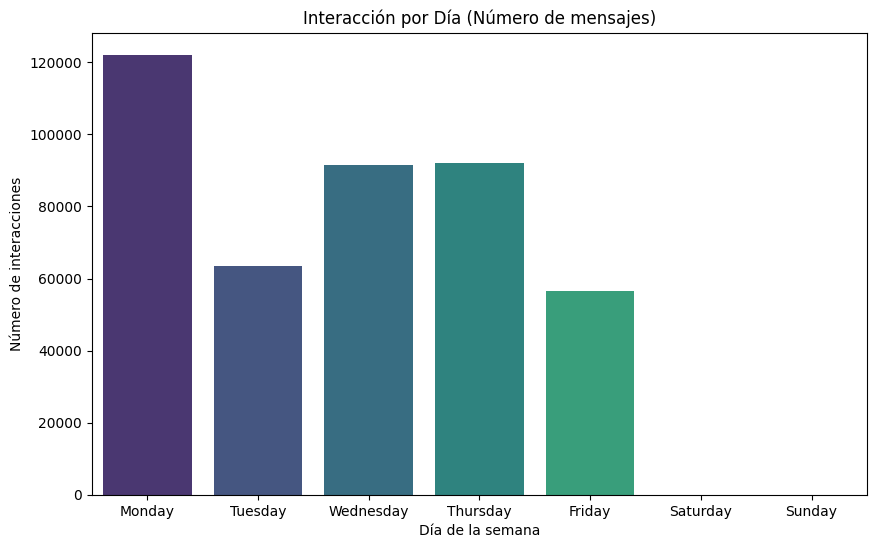

In [55]:
plt.figure(figsize=(10,6))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x="dia_semana", order=order, palette="viridis")
plt.title("Interacción por Día (Número de mensajes)")
plt.xlabel("Día de la semana")
plt.ylabel("Número de interacciones")
plt.show()

# Limpieza de outliers para la edad

### Dado que algunos clientes son extranjeros y la formula que utilizo para obtener la edad a partir del RUT no es valida con ese grupo, elimine el grupo de edad 0 a 20, si bien es posible que algunos dentro de ese rango de edad coticen, son pocos los datos perdidos

In [56]:
# Filtrar el DataFrame
df_filtrado = df[df["intervalo_edad"] != "0-20"]

# Verificar los intervalos de edad restantes
print(df_filtrado["intervalo_edad"].value_counts())

intervalo_edad
41-50    140141
31-40    125044
61+       66280
51-60     53666
21-30     19676
0-20          0
Name: count, dtype: int64


# Analisis de comportamiento segun la edad

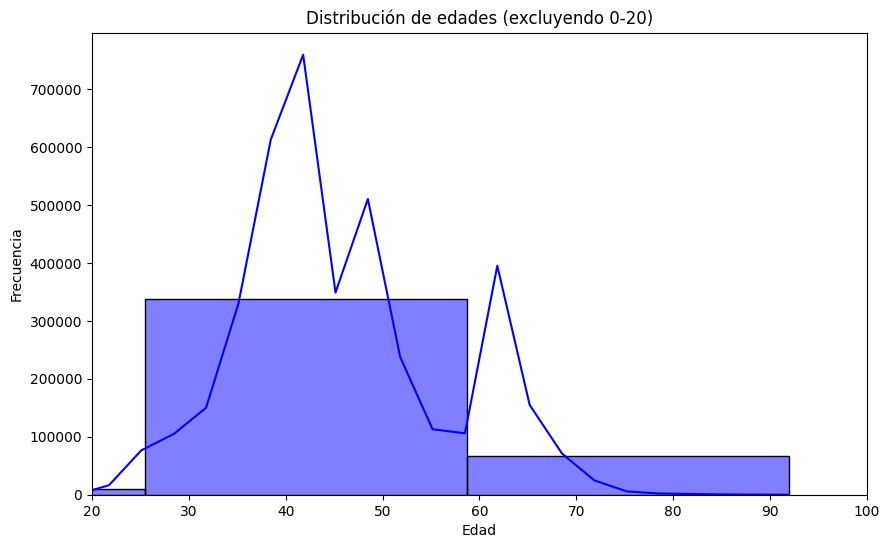

In [57]:
# Gráfico de distribución de edades (sin "0-20")
plt.figure(figsize=(10, 6))
sns.histplot(df_filtrado["edad"], bins=20, kde=True, color="blue")
plt.title("Distribución de edades (excluyendo 0-20)")
plt.xlabel("Edad")
plt.xlim(20, 100)
plt.ylabel("Frecuencia")
plt.show()


C:\Users\luis\AppData\Local\Temp\ipykernel_23480\3226851815.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


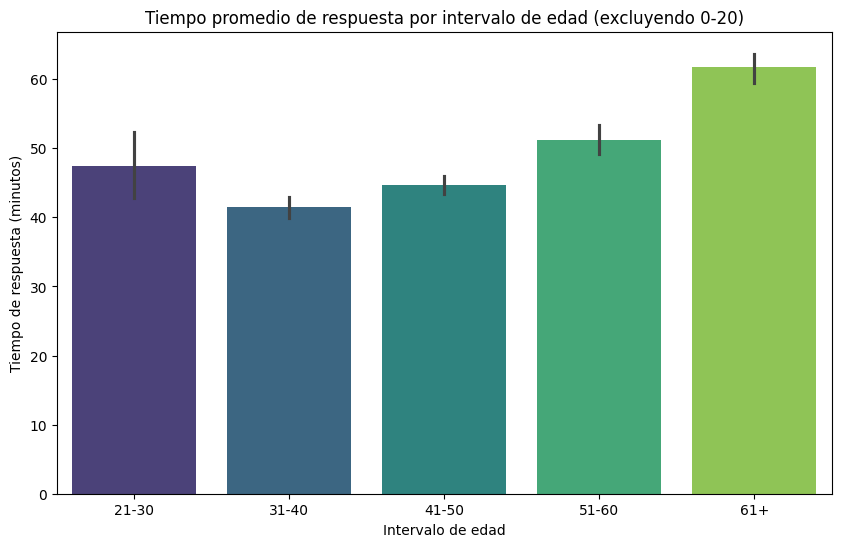

In [58]:
# Gráfico de tiempo de respuesta por intervalo de edad
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_filtrado, 
    x="intervalo_edad", 
    y="tiempo_respuesta_minutos", 
    palette="viridis", 
    order=["21-30", "31-40", "41-50", "51-60", "61+"]
)
plt.title("Tiempo promedio de respuesta por intervalo de edad (excluyendo 0-20)")
plt.xlabel("Intervalo de edad")
plt.ylabel("Tiempo de respuesta (minutos)")
plt.show()

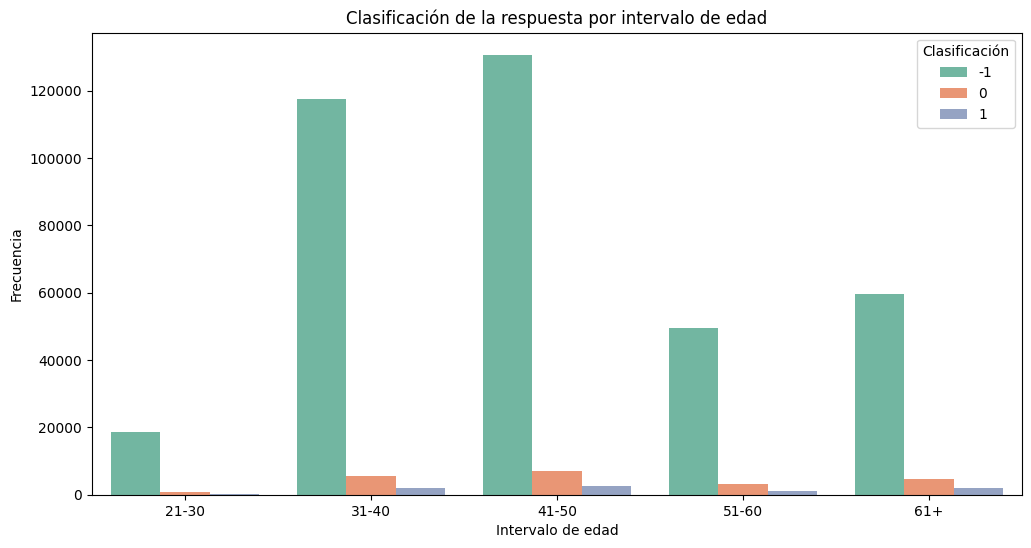

In [59]:
# Gráfico de clasificación de la respuesta por intervalo de edad
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_filtrado, 
    x="intervalo_edad", 
    hue="clasificacion_respuesta", 
    palette="Set2", 
    order=["21-30", "31-40", "41-50", "51-60", "61+"]
)
plt.title("Clasificación de la respuesta por intervalo de edad")
plt.xlabel("Intervalo de edad")
plt.ylabel("Frecuencia")
plt.legend(title="Clasificación")
plt.show()

### Aca se observa un patron, en cuanto va aumentando la edad tambien aumenta el tiempo de respuesta

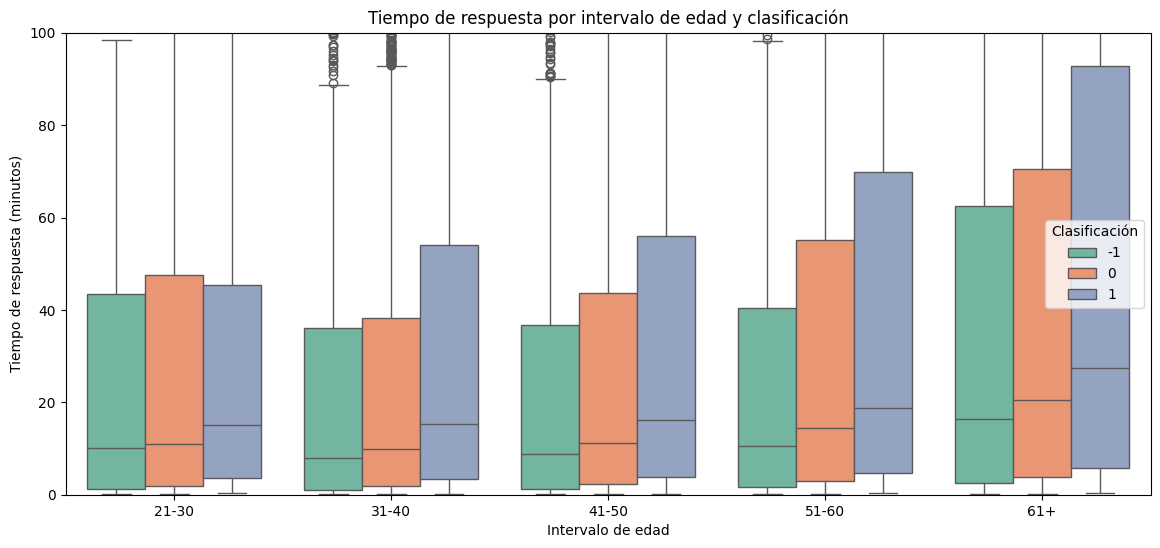

In [60]:
# Gráfico de tiempo de respuesta por intervalo de edad y clasificación
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_filtrado, 
    x="intervalo_edad", 
    y="tiempo_respuesta_minutos", 
    hue="clasificacion_respuesta", 
    palette="Set2", 
    order=["21-30", "31-40", "41-50", "51-60", "61+"]
)
plt.title("Tiempo de respuesta por intervalo de edad y clasificación")
plt.xlabel("Intervalo de edad")
plt.ylabel("Tiempo de respuesta (minutos)")
plt.ylim(0, 100)
plt.legend(title="Clasificación")
plt.show()

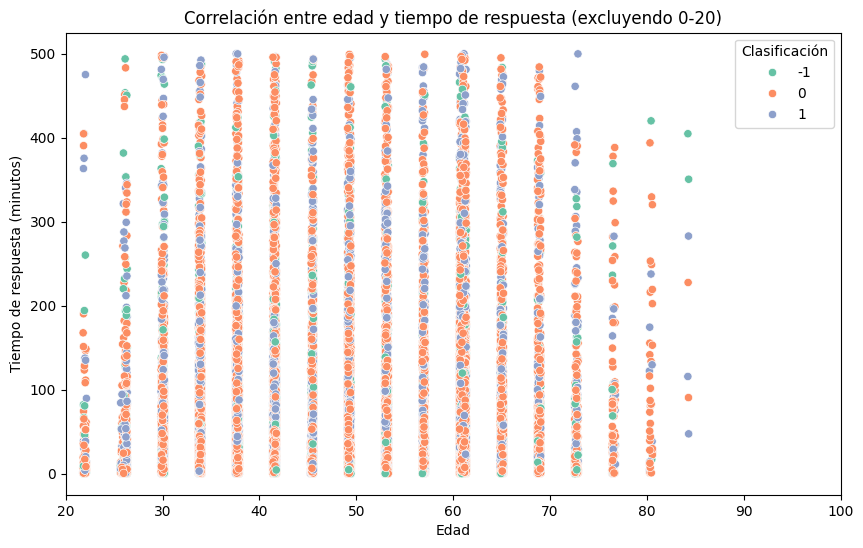

Correlación entre edad y tiempo de respuesta: 0.07


In [61]:
# Gráfico de dispersión y correlación
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_filtrado, 
    x="edad", 
    y="tiempo_respuesta_minutos", 
    hue="clasificacion_respuesta", 
    palette="Set2"
)
plt.title("Correlación entre edad y tiempo de respuesta (excluyendo 0-20)")
plt.xlabel("Edad")
plt.xlim(20, 100)

plt.ylabel("Tiempo de respuesta (minutos)")
plt.legend(title="Clasificación")
plt.show()

# Calcular correlación
correlacion = df_filtrado["edad"].corr(df_filtrado["tiempo_respuesta_minutos"])
print(f"Correlación entre edad y tiempo de respuesta: {correlacion:.2f}")

In [62]:
# Eliminar filas con edades negativas
df_filtrado = df_filtrado[df_filtrado['edad'] > 0]

# Calcular e imprimir la edad mínima y máxima
print("Edad mínima:", df_filtrado['edad'].min())
print("Edad máxima:", df_filtrado['edad'].max())


Edad mínima: 21.800700000000006
Edad máxima: 91.91339999999991


### Se intentó segmentar las variables edad, tiempo_respuesta_minutos, hora, día_semana y clasificación_respuesta para identificar patrones. Sin embargo, el análisis no es útil porque no hay suficientes clientes repetidos en WhatsApp para establecer tendencias confiables. Aunque se observan clientes con tiempos de respuesta variables, esta información no es relevante, ya que se necesitaría un alto volumen de mensajes enviados al mismo cliente para determinar con certeza si responde rápido o lento.

In [63]:

# Seleccionar variables
variables = ['edad', 'tiempo_respuesta_minutos', 'hora', 'dia_semana', 'clasificacion_respuesta']
df_segmentacion = df_filtrado[variables].dropna()

# Filtrar edades fuera del rango 20-60
df_segmentacion = df_segmentacion[(df_segmentacion['edad'] >= 20) & (df_segmentacion['edad'] <= 60)]

# Separar variables numéricas y categóricas
num_vars = ['edad', 'tiempo_respuesta_minutos']
cat_vars = ['hora', 'dia_semana', 'clasificacion_respuesta']
cat_indices = [2, 3, 4]  # Índices de las columnas categóricas en el DataFrame

# Convertir variables categóricas a string
for var in cat_vars:
    df_segmentacion[var] = df_segmentacion[var].astype(str)

# Ajustar el modelo k-prototypes
n_clusters = 3  # Número de clusters deseados
kproto = KPrototypes(n_clusters=n_clusters, init='Cao', verbose=2)
clusters = kproto.fit_predict(df_segmentacion, categorical=cat_indices)

# Agregar los clusters al DataFrame
df_segmentacion['cluster'] = clusters

# Analizar resultados
print("\nCentroides de variables numéricas:")
print(df_segmentacion.groupby('cluster')[num_vars].mean())

print("\nModos de variables categóricas:")
print(df_segmentacion.groupby('cluster')[cat_vars].agg(lambda x: x.value_counts().index[0]))

# Visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_segmentacion, x='edad', y='tiempo_respuesta_minutos', hue='cluster', palette='Set2')
plt.title('Distribución de clusters')
plt.xlabel('Edad')
plt.ylabel('Tiempo de respuesta (minutos)')
plt.show()

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2551, ncost: 27494825.695520185


KeyboardInterrupt: 

## En qué horas hay más actividad o qué tipo de respuesta es más común en ciertos momentos del día

<Figure size 1200x600 with 0 Axes>

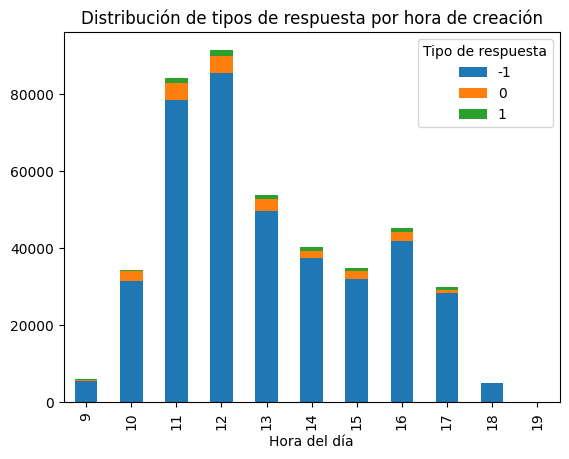

<Figure size 1600x800 with 0 Axes>

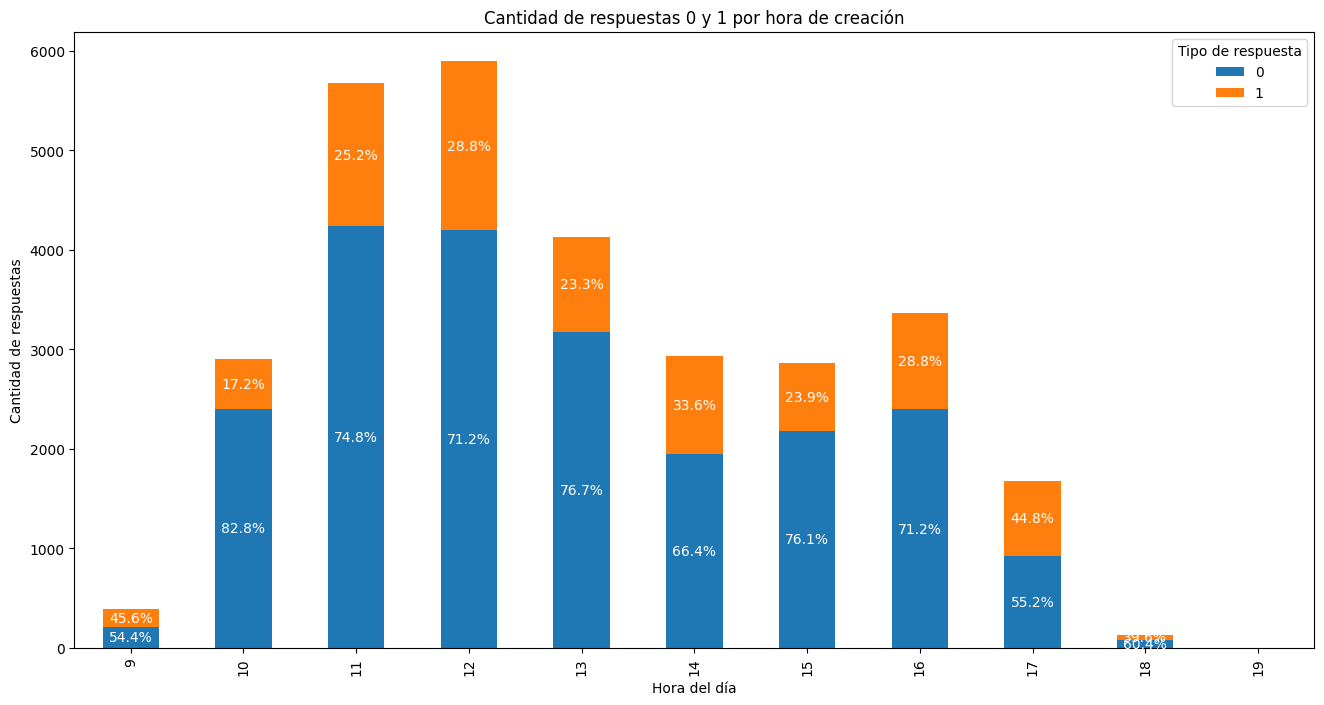

In [ ]:


# Convertir 'created' a formato datetime
df['created'] = pd.to_datetime(df['created'])

# Extraer la hora del día
df['hora_creacion'] = df['created'].dt.hour

# Clasificar las respuestas (esto depende de tus datos)
# Por ejemplo, podrías tener una función 'clasificar_respuesta'
# df['clasificacion_respuesta'] = df['message_text_first_response'].apply(clasificar_respuesta)

# Agrupar por hora y tipo de respuesta, y contar ocurrencias
conteo_respuestas = df.groupby(['hora_creacion', 'clasificacion_respuesta']).size().unstack(fill_value=0)

# Crear un gráfico de barras apiladas
plt.figure(figsize=(12, 6))
conteo_respuestas.plot(kind='bar', stacked=True)
plt.title('Distribución de tipos de respuesta por hora de creación')
plt.xlabel('Hora del día')
# Filtrar solo respuestas de tipo 0 y 1
df_respuestas = conteo_respuestas[[0, 1]]
# Calcular el porcentaje en cada hora
df_porcentaje = df_respuestas.div(df_respuestas.sum(axis=1), axis=0) * 100



plt.legend(title='Tipo de respuesta')
plt.show()
# Aumentar el tamaño del gráfico y usar los recuentos en el eje y
plt.figure(figsize=(16, 8))
ax = df_respuestas.plot(kind='bar', stacked=True, figsize=(16, 8))
plt.title('Cantidad de respuestas 0 y 1 por hora de creación')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de respuestas')

# Añadir porcentaje dentro de cada segmento de la barra
for i, (hora, row) in enumerate(df_respuestas.iterrows()):
    cumulative = 0
    for col in df_respuestas.columns:
        value = row[col]
        porcentaje = df_porcentaje.loc[hora, col]
        if value > 0:
            ax.text(i, cumulative + value / 2, f'{porcentaje:.1f}%', ha='center', va='center', color='white', fontsize=10)
        cumulative += value

plt.legend(title='Tipo de respuesta')
plt.show()

## Tasa de respuesta que deriva a ejecutivo en templates de wsp

Resumen por template:
                                                    positive_count
template                                                          
afp_capital_wr_sugerencia_fondo_rentabilidad_wr               2420
agosto_abtest_sdf_wr_perfil                                   1960
afp_capital_cliente_no_contactado_asesoria                    1749
war_room_sept_acceso_web                                       227
sdf_sin_perfil                                                 198
afp_capital_clientes_acceso_web_war_room_v2                    189
afp_capital_cliente_sin_contacto_sin_transaccio...             178
trx_wr_var_unica_sept                                          155
afp_capital_clientes_rentabilidad_y_sugerencia_...             132
afp_capital_clientes_variables_unicas_wr                        88
Resumen por template:
                                                    positive_count  total  \
template                                                                   

C:\Users\luis\AppData\Local\Temp\ipykernel_23480\2988280713.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=group_reset, y='template', x='positive_rate', palette='viridis')


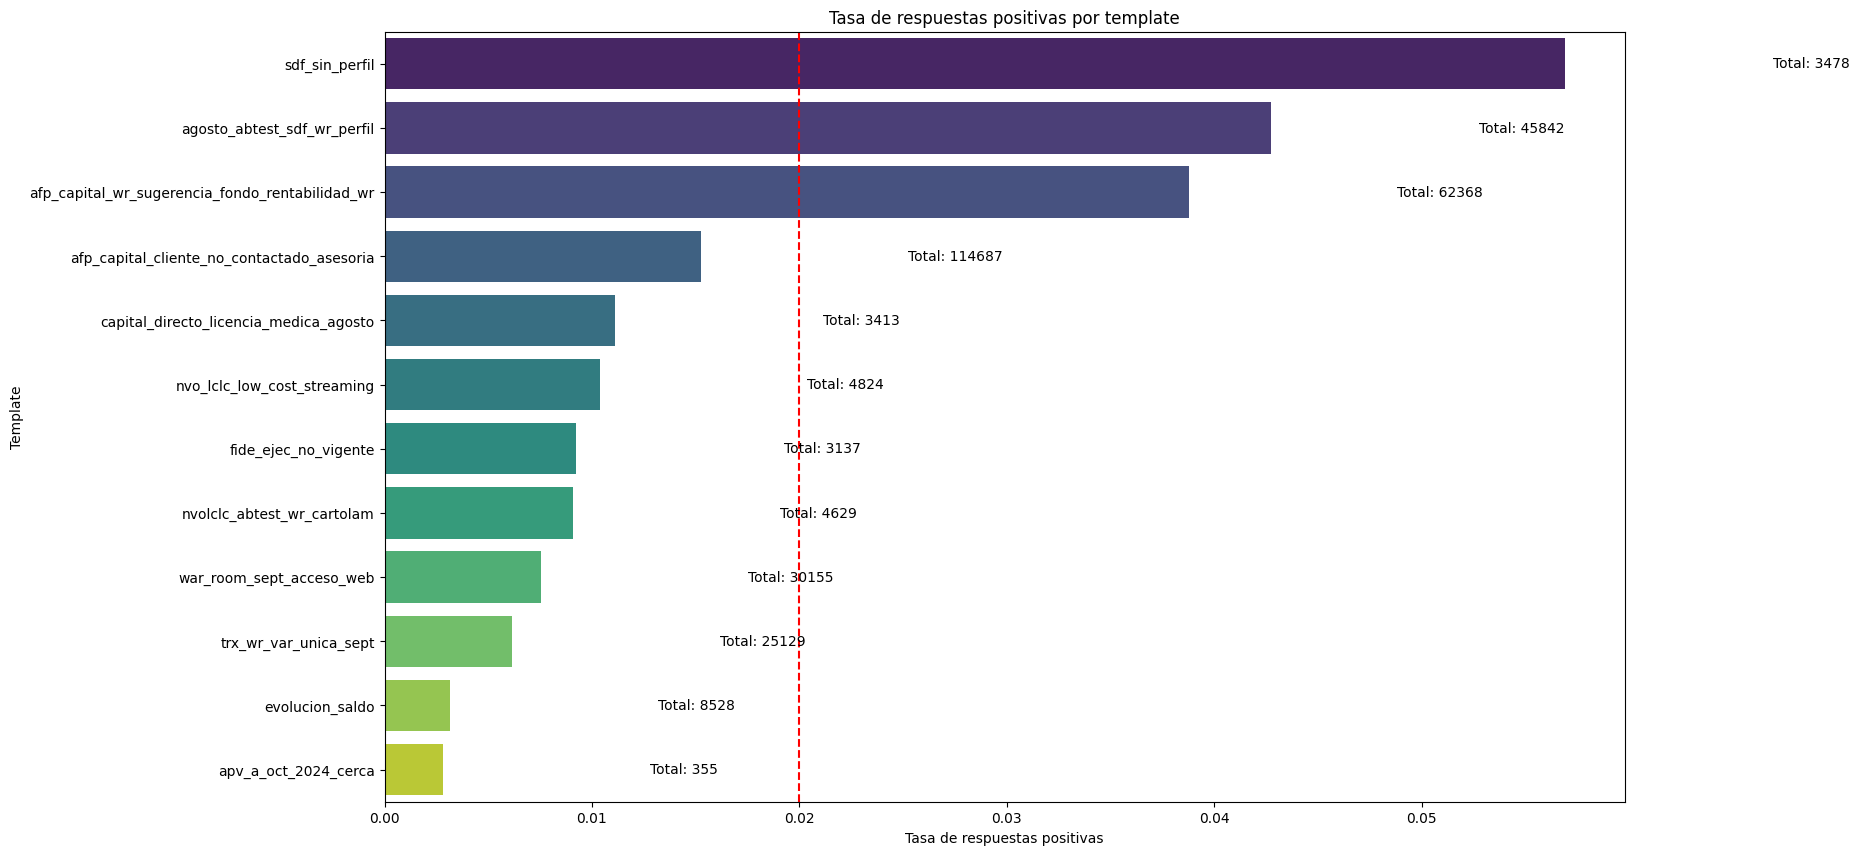

In [65]:
import seaborn as sns



# Visualizar la tasa de respuestas positivas por template
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# Resetear el índice para utilizar seaborn
# Filtrar filas donde exista template y clasificacion_respuesta, considerando solo respuestas positivas (valor 1)
df_template = df.dropna(subset=['template', 'clasificacion_respuesta'])
df_template = df_template[df_template['clasificacion_respuesta'] == 1]

# Agrupar por template contando las respuestas positivas
group = df_template.groupby('template')['clasificacion_respuesta'].count()
group = group.to_frame(name='positive_count')

# Ordenar para ver los templates con mayor cantidad de respuestas positivas
group = group.sort_values(by='positive_count', ascending=False)
print("Resumen por template:")
print(group.head(10))

# Calcular la tasa de respuestas positivas y el total de envíos por template
df_all = df.dropna(subset=['template', 'clasificacion_respuesta'])
group_total = df_all.groupby('template')['clasificacion_respuesta'].count().to_frame(name='total')
group_positive = df_all[df_all['clasificacion_respuesta'] == 1].groupby('template')['clasificacion_respuesta'].count().to_frame(name='positive_count')
group_merged = group_positive.merge(group_total, left_index=True, right_index=True)
group_merged['positive_rate'] = group_merged['positive_count'] / group_merged['total']
group = group_merged.sort_values(by='positive_rate', ascending=False)
print("Resumen por template:")
print(group.head(10))
allowed_templates = [
    "agosto_abtest_sdf_wr_perfil",
    "nvo_lclc_low_cost_streaming",
    "multiplicador_personalizado",
    "nvolclc_abtest_wr_cartolam",
    "afp_capital_cliente_no_contactado_asesoria",
    "war_room_sept_acceso_web",
    "trx_wr_var_unica_sept",
    "apv_a_cumplido_oct_2024_2",
    "apv_a_oct_2024_cerca",
    "apv_a_oct_2024_flujo",
    "apv_b_oct_2024",
    "capital_directo_licencia_medica_agosto",
    "fide_ejec_no_vigente",
    "afp_capital_wr_sugerencia_fondo_rentabilidad_wr",
    "evolucion_saldo",
    "sdf_sin_perfil"
]

group = group.loc[group.index.isin(allowed_templates)]
print("Resumen filtrado por templates:")
print(group.head(10))
# Resetear el índice para utilizar seaborn
group_reset = group.reset_index()

# Graficar la tasa de respuestas positivas y anotar la cantidad total de envíos por template
plt.gcf().set_size_inches(16, 10)
ax = sns.barplot(data=group_reset, y='template', x='positive_rate', palette='viridis')
for i, row in group_reset.iterrows():
    ax.text(row['positive_rate'] + 0.01, i, f"Total: {row['total']}", color='black', va='center')
plt.title('Tasa de respuestas positivas por template')
plt.xlabel('Tasa de respuestas positivas')
plt.ylabel('Template')
plt.axvline(x=0.02, color='red', linestyle='--')
plt.show()

## Busqueda de si aumenta la positividad segun la hora para el template mas utilizado

Hora del día con mayor porcentaje de respuestas positivas:
hora             9.000000
positive_rate    2.558635
Name: 0, dtype: float64


C:\Users\luis\AppData\Local\Temp\ipykernel_23480\2842752446.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=porcentaje_por_hora, x="hora", y="positive_rate", palette="viridis")


Text(0, 0.5, 'Porcentaje de respuestas positivas (%)')

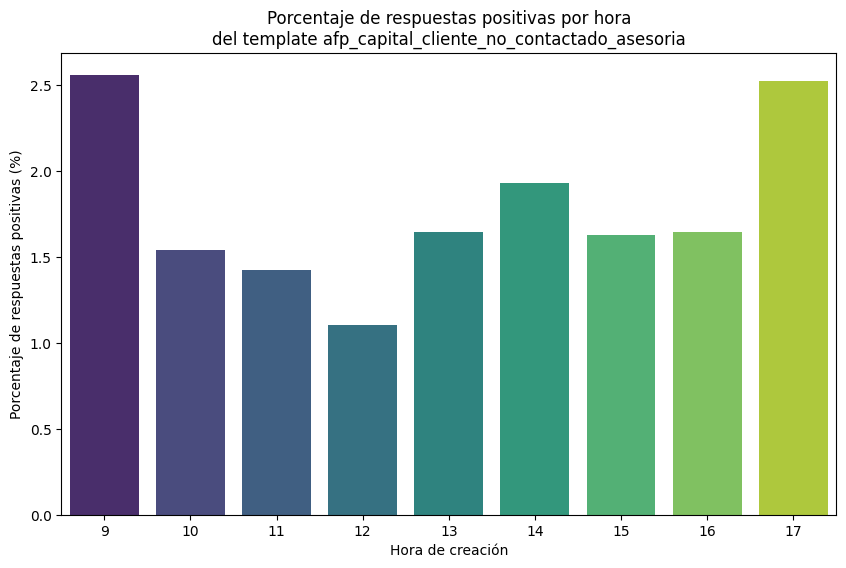

In [66]:
import seaborn as sns

# Filtrar los datos para el template "afp_capital_cliente_no_contactado_asesoria"
df_filtrado_template = df_all[df_all["template"] == "afp_capital_cliente_no_contactado_asesoria"]

# Agrupar por 'hora_creacion' y calcular el % de respuestas positivas (donde clasificacion_respuesta == 1)
porcentaje_por_hora = (
    df_filtrado_template.groupby("hora")["clasificacion_respuesta"]
    .apply(lambda x: (x == 1).sum() / x.count() * 100)
    .reset_index(name="positive_rate")
)

# Encontrar la hora con el máximo porcentaje de respuestas positivas
max_row = porcentaje_por_hora.loc[porcentaje_por_hora["positive_rate"].idxmax()]

print("Hora del día con mayor porcentaje de respuestas positivas:")
print(max_row)

# Opcional: graficar la evolución del porcentaje a lo largo del día
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=porcentaje_por_hora, x="hora", y="positive_rate", palette="viridis")
plt.title("Porcentaje de respuestas positivas por hora\ndel template afp_capital_cliente_no_contactado_asesoria")
plt.xlabel("Hora de creación")
plt.ylabel("Porcentaje de respuestas positivas (%)")


   hora  cantidad_mensajes
0     9                469
1    10               8909
2    11              25726
3    12              24111
4    13              16732
5    14               6122
6    15              11300
7    16              16682
8    17               4636
Total de mensajes enviados: 114687


C:\Users\luis\AppData\Local\Temp\ipykernel_23480\780042137.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mensajes_por_hora, x="hora", y="cantidad_mensajes", palette="viridis")


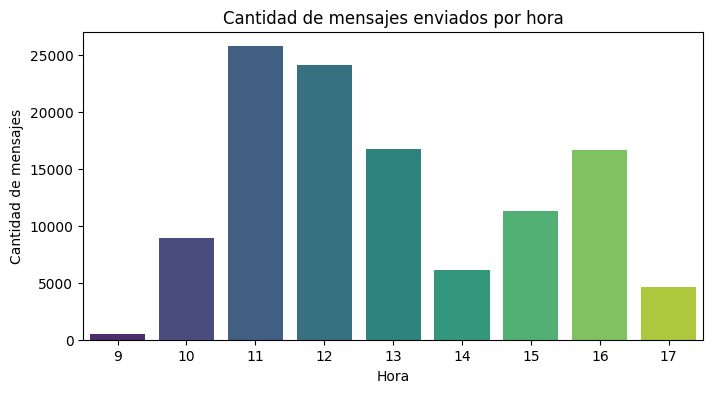

In [67]:
# Filtrar mensajes con el template de interés
df_template = df[df["template"] == "afp_capital_cliente_no_contactado_asesoria"]

# Contar los mensajes enviados por cada hora
mensajes_por_hora = df_template.groupby("hora").size().reset_index(name="cantidad_mensajes")
total_mensajes = mensajes_por_hora["cantidad_mensajes"].sum()
print(mensajes_por_hora)
print("Total de mensajes enviados:", total_mensajes)

plt.figure(figsize=(8, 4))
sns.barplot(data=mensajes_por_hora, x="hora", y="cantidad_mensajes", palette="viridis")
plt.title("Cantidad de mensajes enviados por hora")
plt.xlabel("Hora")
plt.ylabel("Cantidad de mensajes")
plt.show()

In [73]:
# Filtrar el DataFrame para el template deseado y contar las filas en las que 'clasificacion_respuesta' es 1
count_template = df[
    (df['template'] == 'afp_capital_cliente_no_contactado_asesoria') &
    (df['clasificacion_respuesta'] == 1)
].shape[0]
template_df = df[df['template'] == 'afp_capital_cliente_no_contactado_asesoria']
agrupado = template_df.groupby('hora')['clasificacion_respuesta'].agg(
    total_mensajes='count',
    mensajes_positivos=lambda x: (x == 1).sum()
).reset_index()
agrupado['porcentaje_positividad'] = 100 * agrupado['mensajes_positivos'] / agrupado['total_mensajes']
print("Porcentaje de positividad por hora para el template 'afp_capital_cliente_no_contactado_asesoria':")
print(agrupado)
print("Cantidad de 'clasificacion_respuesta' igual a 1 para el template 'afp_capital_cliente_no_contactado_asesoria':", count_template)

Porcentaje de positividad por hora para el template 'afp_capital_cliente_no_contactado_asesoria':
   hora  total_mensajes  mensajes_positivos  porcentaje_positividad
0     9             469                  12                2.558635
1    10            8909                 137                1.537771
2    11           25726                 366                1.422685
3    12           24111                 266                1.103231
4    13           16732                 275                1.643557
5    14            6122                 118                1.927475
6    15           11300                 184                1.628319
7    16           16682                 274                1.642489
8    17            4636                 117                2.523727
Cantidad de 'clasificacion_respuesta' igual a 1 para el template 'afp_capital_cliente_no_contactado_asesoria': 1749


In [77]:
# Contar, de forma general, las filas en las que 'clasificacion_respuesta' es 1
count_all = df[df['clasificacion_respuesta'] == 1].shape[0]

# Agrupar el DataFrame por 'hora' y calcular el total de mensajes y los mensajes positivos
agrupado_all = df.groupby('hora')['clasificacion_respuesta'].agg(
    total_mensajes='count',
    mensajes_positivos=lambda x: (x == 1).sum()
).reset_index()

# Calcular el porcentaje de positividad por hora
agrupado_all['porcentaje_positividad'] = 100 * agrupado_all['mensajes_positivos'] / agrupado_all['total_mensajes']

print("Porcentaje de positividad por hora:")
print(agrupado_all)
print("Cantidad total de 'clasificacion_respuesta' igual a 1:", count_all)

Porcentaje de positividad por hora:
    hora  total_mensajes  mensajes_positivos  porcentaje_positividad
0      9            5938                 177                2.980802
1     10           34454                 500                1.451210
2     11           84310                1432                1.698494
3     12           91577                1697                1.853085
4     13           53867                 962                1.785880
5     14           40376                 987                2.444521
6     15           34787                 684                1.966252
7     16           45308                 970                2.140902
8     17           29970                 753                2.512513
9     18            5023                  53                1.055146
10    19              10                   0                0.000000
Cantidad total de 'clasificacion_respuesta' igual a 1: 8215


### Posibles valores en la columna "status"

In [34]:
# Mostrar los valores únicos en la columna "status" y contar cuántos hay
unique_status = df["status"].unique()
print("Valores únicos en 'status':", unique_status)
# Filtrar filas: eliminar aquellas con status nulo o 'unknown'
df = df[df["status"].notnull() & (df["status"] != "unknown") & (df["status"] != "status")]

# Mostrar los valores únicos en la columna "status" y contar cuántos hay después del filtrado
unique_status = df["status"].unique()
print("Valores únicos en 'status' después del filtrado:", unique_status)
print("Número de valores únicos en 'status':", len(unique_status))

Valores únicos en 'status': ['Read by recipient' 'Received by recipient' 'Sent to WhatsApp'
 'With error' 'status' nan 'unknown']
Valores únicos en 'status' después del filtrado: ['Read by recipient' 'Received by recipient' 'Sent to WhatsApp'
 'With error']
Número de valores únicos en 'status': 4


# Analisis de lectura de mensajes

Tasa de mensajes leídos por hora:
    hora     leido
0    9.0  0.437016
1   10.0  0.434667
2   11.0  0.447325
3   12.0  0.466252
4   13.0  0.430059
5   14.0  0.416361
6   15.0  0.416937
7   16.0  0.419330
8   17.0  0.462129
9   18.0  0.669122
10  19.0  0.400000


C:\Users\luis\AppData\Local\Temp\ipykernel_23480\835293738.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tasa_leido, x='hora', y='leido', palette='viridis')


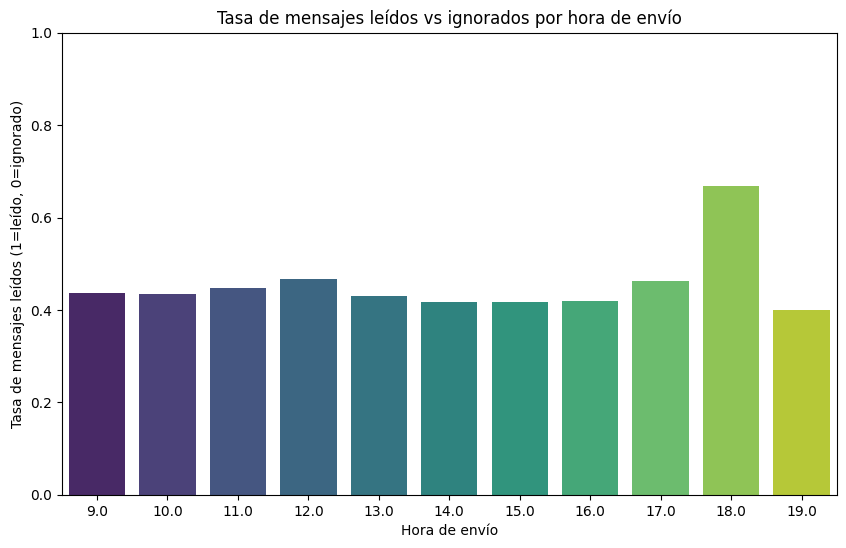

Coeficiente de correlación entre hora de envío y status leído: 0.00


In [35]:
# Crear una columna 'leido' donde:
#  - valor 1 indica que el mensaje fue leído (status distinto a "Read by recipient" y no es NaN)
#  - valor 0 indica que fue ignorado (status es "Read by recipient" o está vacío)
df['leido'] = df['status'].apply(lambda x: 1 if pd.notna(x) and x != "Read by recipient" else 0)

# Calcular la tasa de mensajes leídos (1) agrupada por la hora de envío
tasa_leido = df.groupby('hora')['leido'].mean().reset_index()

print("Tasa de mensajes leídos por hora:")
print(tasa_leido)

# Graficar la tasa de mensajes leídos por hora
plt.figure(figsize=(10,6))
sns.barplot(data=tasa_leido, x='hora', y='leido', palette='viridis')
plt.title("Tasa de mensajes leídos vs ignorados por hora de envío")
plt.xlabel("Hora de envío")
plt.ylabel("Tasa de mensajes leídos (1=leído, 0=ignorado)")
plt.ylim(0,1)
plt.show()

# Calcular la correlación entre la hora de envío y la variable 'leido'
corr = df[['hora', 'leido']].corr().iloc[0,1]
print(f"Coeficiente de correlación entre hora de envío y status leído: {corr:.2f}")

In [36]:
# Filtrar el DataFrame para el template de interés
template_filter = 'afp_capital_wr_sugerencia_fondo_rentabilidad_wr'
df_template_analysis = df[df['template'] == template_filter]

# Contar respuestas agrupadas por "clasificacion_respuesta" en el orden: 0, 1 y -1
# (donde 0: "No", 1: "Si", -1: "Indiferente")
counts = df_template_analysis['clasificacion_respuesta'].value_counts().reindex([0, 1, -1], fill_value=0)
total = counts.sum()

print("Análisis de respuestas para el template:", template_filter)
print("Conteo por tipo de respuesta:")
for resp, cnt in counts.items():
    print(f"Respuesta {resp} ({mapping.get(resp)}): {cnt}")
print(f"Total de respuestas: {total}")

Análisis de respuestas para el template: afp_capital_wr_sugerencia_fondo_rentabilidad_wr
Conteo por tipo de respuesta:


NameError: name 'mapping' is not defined

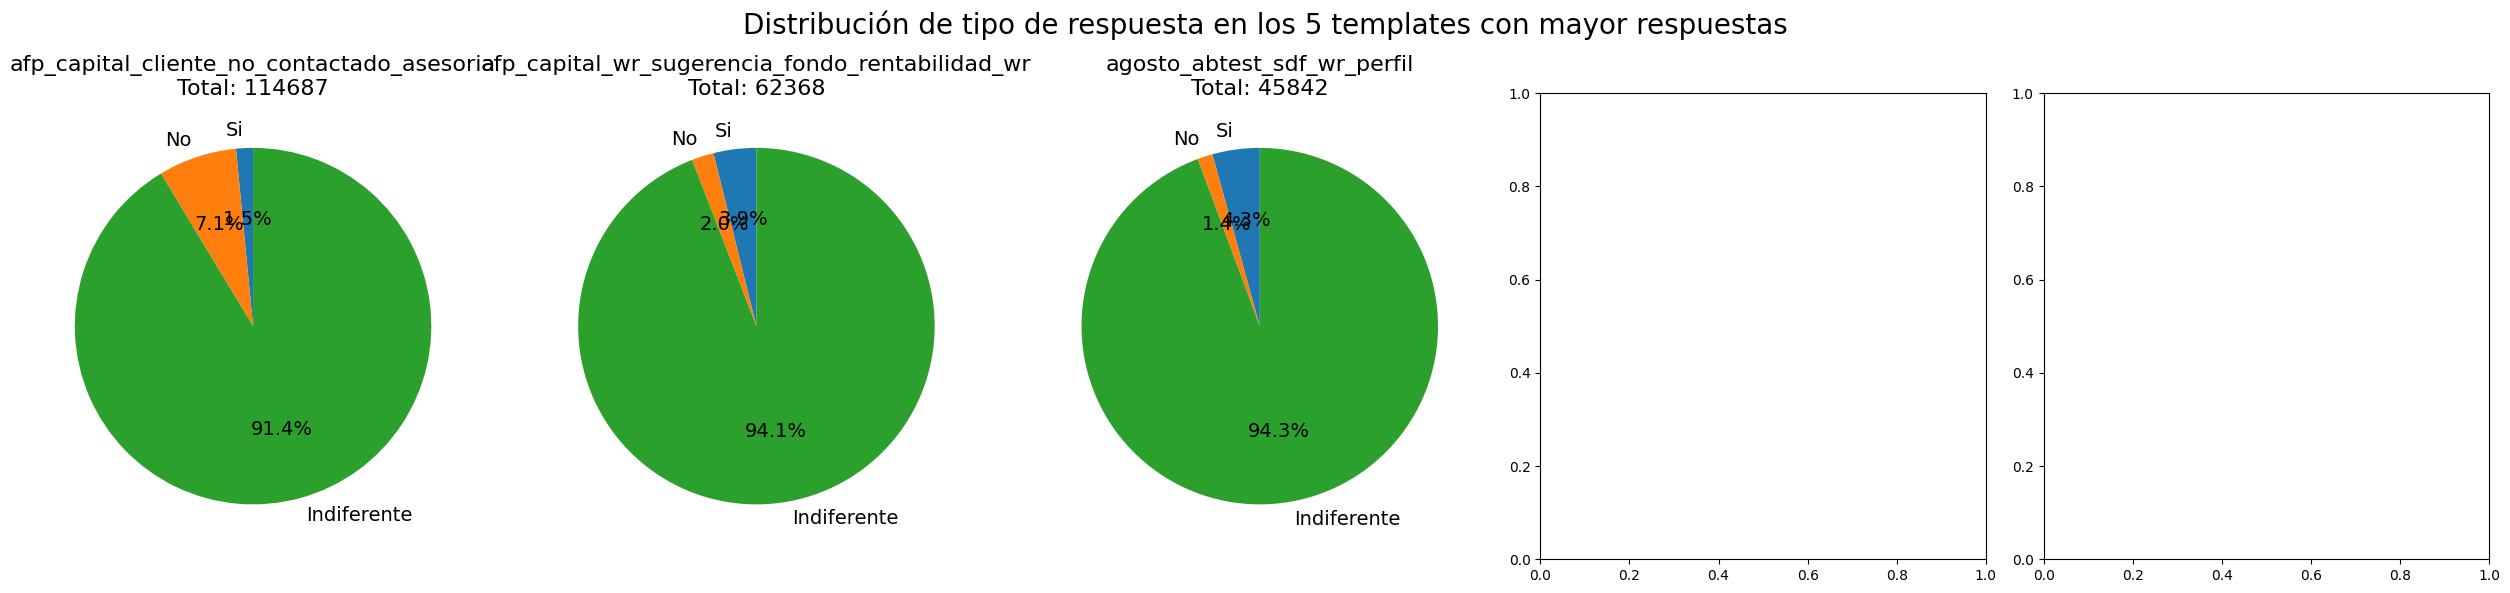

In [ ]:
# Seleccionar los 5 templates con mayor cantidad de respuestas
top_templates = df_all['template'].value_counts().head(3).index.tolist()

# Mapeo de los códigos de respuesta a etiquetas
mapping = {1: 'Si', 0: 'No', -1: 'Indiferente'}

# Crear 5 gráficos circulares grandes en una fila
fig, axes = plt.subplots(1, 5, figsize=(25, 6))
for ax, tpl in zip(axes, top_templates):
    # Filtrar las respuestas para el template actual y contar por tipo de respuesta
    data = df_all[df_all['template'] == tpl]['clasificacion_respuesta']
    counts = data.value_counts().reindex([1, 0, -1], fill_value=0)
    
    # Graficar el gráfico circular (pie chart)
    ax.pie(counts, labels=[mapping.get(k) for k in counts.index],
           autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
    ax.set_title(f"{tpl}\nTotal: {counts.sum()}", fontsize=16)

plt.suptitle("Distribución de tipo de respuesta en los 5 templates con mayor respuestas", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Filtrar mensajes con status "Read by recipient" y el resto
read_mask = df['status'] == "Read by recipient"
df_read = df[read_mask]
df_not_read = df[~read_mask]

# Calcular la proporción de respuestas positivas en cada grupo
prop_read = (df_read['clasificacion_respuesta'] == 1).mean()
prop_not_read = (df_not_read['clasificacion_respuesta'] == 1).mean()

print("Proporción de respuestas positivas (Read by recipient):", prop_read)
print("Proporción de respuestas positivas (Otros status):", prop_not_read)

if prop_read > prop_not_read:
    print("Los mensajes marcados como 'Read by recipient' tienen mayor probabilidad de recibir una respuesta positiva.")
else:
    print("Los mensajes marcados como 'Read by recipient' NO tienen mayor probabilidad de recibir una respuesta positiva.")

Proporción de respuestas positivas (Read by recipient): 0.02937005680715112
Proporción de respuestas positivas (Otros status): 0.010499369295837353
Los mensajes marcados como 'Read by recipient' tienen mayor probabilidad de recibir una respuesta positiva.
